In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy import wcs
from astropy.io import ascii
from astropy.table import Table, Column, MaskedColumn
from pathlib import Path
from math import trunc
%matplotlib inline

In [2]:
# Retreive all the data from the meta-data file
meta_data = ascii.read('../datared/J0600_meta-data.txt')

# To get nice plots, all the data is sorted by the epoch
epoch_tmp = np.array(meta_data["EPOCH"])
sort = np.argsort(epoch_tmp)
epoch_arr = epoch_tmp[sort]

filters = np.array(meta_data["FILTER"])[sort] # Filters of all the .fits images
airmass_arr = np.array(meta_data["AIRMASS"])[sort] # Airmasses for all the .fits images

fits_name_arr = np.array(meta_data["IMAGE"])[sort] # Name of the original .fits file
files_arr = np.array(meta_data["NEWIMG"])[sort] # Name of the data reduced files

N_files = len(epoch_arr) #nr of files
N_stars = len(ascii.read(files_arr[0])["STARNR"]) #nr of stars
print ("Number of files = {}".format(N_files))
print ("Number of stars = {}".format(N_stars))

Number of files = 1762
Number of stars = 161


In [3]:
# Make a mask for all the filters:
filt = [] #list of the different filters
NimgINf = {} #dictionary of number of images for each filter
for f in filters:
    if f not in filt:
        filt.append(f)
        NimgINf[f] = 1
    else:
        NimgINf[f] +=1
print (filt)
print (NimgINf)

fmask = {}
for f in filt:
    fmask[f] = filters == f

    
# Retreive the flux and fluxerr data from all the other files
flux_tmp = np.zeros((N_files,N_stars))
fluxerr_tmp = np.zeros((N_files,N_stars))

for i in range(N_files):
    file = files_arr[i]
    
    filecontent = ascii.read(file)
    flux_tmp[i] = np.array(filecontent["FLUX"])
    fluxerr_tmp[i] = np.array(filecontent["FLUXERR"])

print (np.shape(flux_tmp))
print (np.shape(fluxerr_tmp))


# Make a dictionary where flux[filter] gives an array with all the data for that filter
# And do the same for epoch, airmass, fits_name and files
flux = {}
fluxerr = {}

epoch = {}
airmass = {}
fits_name = {}
files = {}

for f in filt:
    flux[f] = flux_tmp[fmask[f]]
    fluxerr[f] = fluxerr_tmp[fmask[f]]
    
    epoch[f] = epoch_arr[fmask[f]]
    airmass[f] = airmass_arr[fmask[f]]
    fits_name[f] = fits_name_arr[fmask[f]]
    files[f] = files_arr[fmask[f]]


['gp', 'I', 'V', 'B', 'ip', 'up', 'rp']
{'gp': 769, 'I': 1, 'V': 1, 'B': 1, 'ip': 630, 'up': 36, 'rp': 324}
(1762, 161)
(1762, 161)


In [4]:
# I want to exclude the I, V, B and 'up' filter so I do that here:
filt = ['gp', 'ip', 'rp']

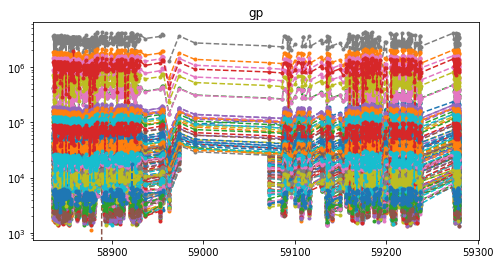

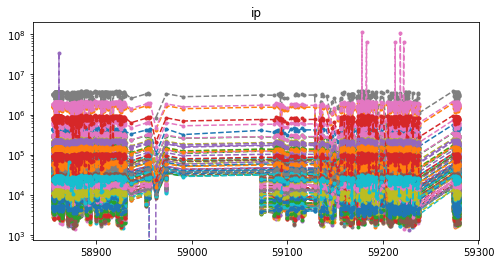

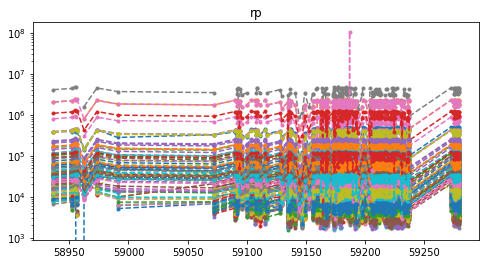

In [5]:
# Testing what the data looks like

# plotting all the flux against epoch for different filters
for f in filt:
    plt.figure(figsize=(8,4))
    #for i in range(N_stars):
    plt.plot(epoch[f],flux[f],linestyle='dashed',marker='.')# label="Star "+str(j), yerr=fluxerr[f] ,fmt='--.')
    plt.title(f)
    #plt.legend(bbox_to_anchor=(1, 1), loc='upper left')
    plt.yscale('log')
    plt.show()

# Filtering for faint stars and bad photometry

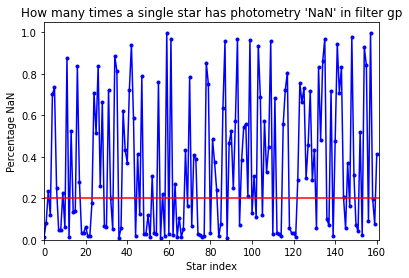

Number of included stars for filter gp = 70/161 (43.5%)


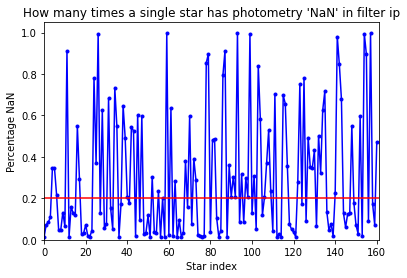

Number of included stars for filter ip = 84/161 (52.2%)


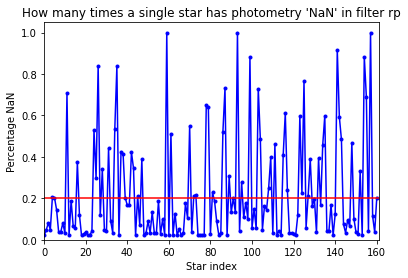

Number of included stars for filter rp = 103/161 (64.0%)


In [6]:
# Make a mask to filter bad stars
maxp_NaN_s = .2 # maximum percentage of NaN's across all filters before it is excluded ##MAKE THIS FILTER SPECIFIC?
star_nan = {} # number of 'NaN' for each star in certain filter
smask = {} # mask of stars included after selection in certain filter
corN_stars = {} # amount of stars included after selection in certain filter
for f in filt:
    star_nan[f] = np.sum(np.isnan(flux[f]),axis=0) 
    smask[f] = star_nan[f]/NimgINf[f] <= maxp_NaN_s
    corN_stars[f] = np.sum(smask[f])

# Plotting the amount of NaN per star, if below red line -> star is included
for f in filt:
    plt.plot(star_nan[f]/NimgINf[f],marker='.', c='b')
    plt.plot([0,N_stars],[maxp_NaN_s,maxp_NaN_s],c='r')
    plt.axis(xmin=-.01,ymin=0,xmax=N_stars+.01)
    plt.title("How many times a single star has photometry 'NaN' in filter "+f)
    plt.xlabel("Star index")
    plt.ylabel("Percentage NaN")
    plt.show()

    print ("Number of included stars for filter {} = {}/{} ({:.1f}%)"\
           .format(f,corN_stars[f],N_stars,100*corN_stars[f]/N_stars))


In [7]:
# Simplifying the masks so combining the filter & photometry mask
flux_excls = {}
fluxerr_excls = {}
for f in filt:
    tmp1 = []
    tmp2 = []
    for i in range(NimgINf[f]):
        tmp1.append(flux[f][i][smask[f]])
        tmp2.append(fluxerr[f][i][smask[f]])
    flux_excls[f] = np.array(tmp1)
    fluxerr_excls[f] = np.array(tmp2)

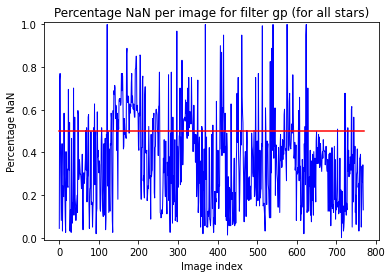

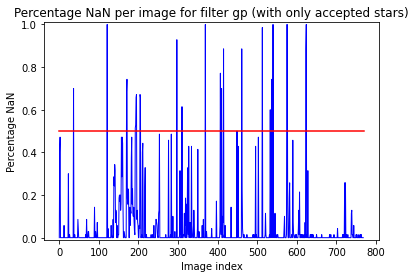

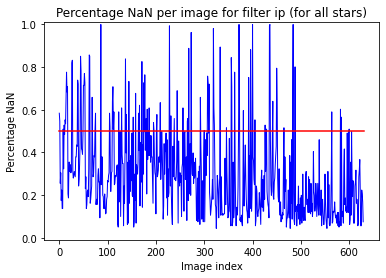

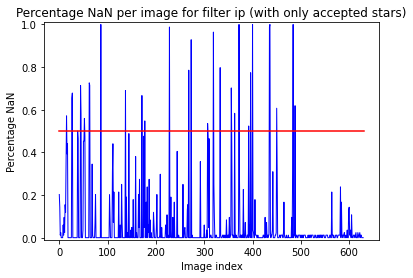

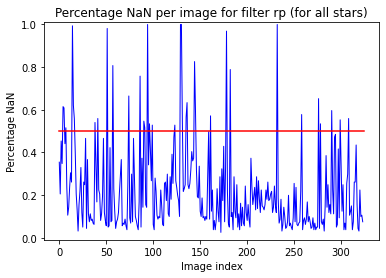

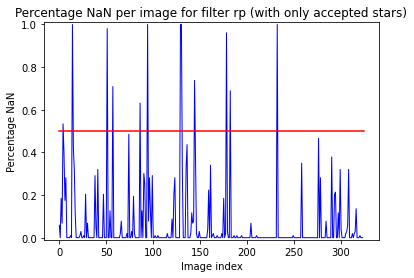

Nr of included images in filter gp = 744/769 (96.7%)
Nr of included images in filter ip = 601/630 (95.4%)
Nr of included images in filter rp = 312/324 (96.3%)


In [8]:
#Make a mask to filter bad photometry
maxp_NaN_e = .5 #maximum percentage of NaN before file is excluded
epoch_NaN = {}
emask = {}
for f in filt:
    tmp = np.sum(np.isnan(flux_excls[f]),axis=1)/corN_stars[f]
    epoch_NaN[f] = tmp
    emask[f] = tmp <= maxp_NaN_e

for f in filt:
    plt.plot(np.sum(np.isnan(flux[f]),axis=1)/N_stars,c='b',linewidth=1)
    plt.plot([0,len(epoch_NaN[f])],[maxp_NaN_e,maxp_NaN_e], c='r')
    plt.title("Percentage NaN per image for filter "+f+" (for all stars)")
    plt.ylabel("Percentage NaN")
    plt.xlabel("Image index") 
    plt.axis(ymin=-.01,ymax=1.01)
    plt.show()
    plt.plot(epoch_NaN[f],c='b',linewidth=1)
    plt.plot([0,len(epoch_NaN[f])],[maxp_NaN_e,maxp_NaN_e], c='r')
    plt.title("Percentage NaN per image for filter "+f+" (with only accepted stars)")
    plt.ylabel("Percentage NaN")
    plt.xlabel("Image index") 
    plt.axis(ymin=-.01,ymax=1.01)
    plt.show()

for f in filt:
    print ("Nr of included images in filter {} = {}/{} ({:.1f}%)"\
           .format(f, np.sum(emask[f]), len(emask[f]), 100*float(np.sum(emask[f]))/float(len(emask[f]))))

In [9]:
# Simplifying the masks so combining the filter & photometry mask
corflux = {}
corfluxerr = {}
corairmass = {}
corfits_name = {}
corfiles = {}
corepoch = {} # make a corrected epoch where the bad photometry is excluded
for f in filt:
    corflux[f] = flux_excls[f][emask[f]]
    corfluxerr[f] = fluxerr_excls[f][emask[f]]
    corairmass[f] = airmass[f][emask[f]]
    corfits_name[f] = fits_name[f][emask[f]]
    corfiles[f] = files[f][emask[f]]
    corepoch[f] = epoch[f][emask[f]]

# Making a mask for the stars without any NaN in their data after exclusion of bad fotometry images
star_withoutnan = {}
print ("Nr of stars without NaN after exclusion bad stars & bad photometry: = {}/{}")
for f in filt:
    star_withoutnan[f] = np.sum(np.isnan(corflux[f]), axis=0) == 0
    print ("Filter {} = {}/{} ({:.1f}%)".format(f,np.sum(star_withoutnan[f]),corN_stars[f],\
                                            100*np.sum(star_withoutnan[f])/corN_stars[f]))

Nr of stars without NaN after exclusion bad stars & bad photometry: = {}/{}
Filter gp = 13/70 (18.6%)
Filter ip = 28/84 (33.3%)
Filter rp = 42/103 (40.8%)


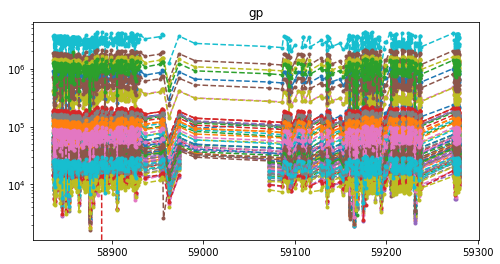

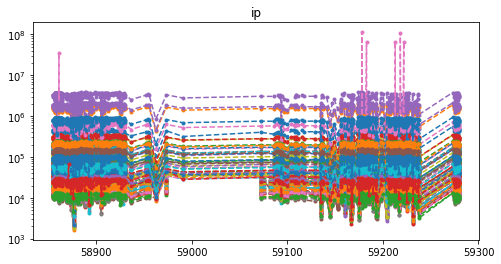

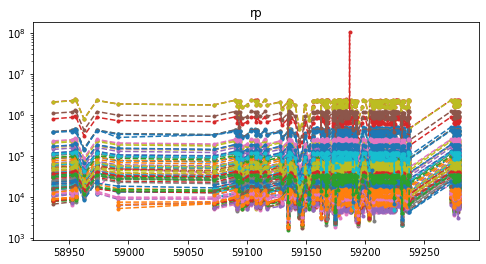

In [10]:
#plotting the flux against epoch for different filters with bad photometry files removed

for f in filt:
    plt.figure(figsize=(8,4))
    #for i in range(N_stars):
    plt.plot(corepoch[f],corflux[f],linestyle='dashed',marker='.')# label="Star "+str(j), yerr=fluxerr[f] ,fmt='--.')
    plt.title(f)
    #plt.legend(bbox_to_anchor=(1, 1), loc='upper left')
    plt.yscale('log')
    plt.show()

In [11]:
# apparently there are some datafiles where the flux & fluxerr is 0.0 ....
for f in filt:
    for e in range(len(corepoch[f])):
        for s in range(corN_stars[f]):
            if corfluxerr[f][e,s] ==0:
                print (corfiles[f][e])
                print (f,e,s,corfluxerr[f][e,s])


../datared/58888.85099_gp.txt
gp 321 33 0.0


# Calculating the meanflux for each star and normalisation factor for each epoch to get double normalised flux

In [12]:
#I want to plot the normalised flux so I first want to devide the flux of all stars by their own mean.
# Decided to do it all with weighted mean

# Calculate the weighted mean flux for each star & the error in this weighted mean
meanflux_star = {}
meanfluxerr_star = {}
for f in filt:
    tmp = []
    tmp2 = []
    for i in range(corN_stars[f]):
        nonNaN = np.isnan(corflux[f][:,i]) == False #exclude non NaN datapoints from calculation
        nonNaN *= np.isnan(corfluxerr[f][:,i]) == False
        if np.sum(nonNaN) != 0:
            weight = (1/corfluxerr[f][:,i][nonNaN])**2
            mfluxstar = np.sum(corflux[f][:,i][nonNaN]*weight)/np.sum(weight)
            tmp.append(mfluxstar)
            tmp2.append(1/np.sum(weight))
        else:
            print ("meanflux_star: Filter {} and star {} has all NaN values".format(f,i))
            tmp.append(np.NaN)
            tmp2.append(np.NaN)
    plt.show()
    meanflux_star[f] = np.array(tmp)
    meanfluxerr_star[f] = np.array(tmp2)
    #print (meanflux_star)

print ("Amount of NaN values in meanflux(err)_star:")
for f in filt:
    print (f,np.sum(np.isnan(meanflux_star[f])))
    print (f,np.sum(np.isnan(meanfluxerr_star[f])))

#Then I want to devide the fluxes of all stars at one epoch by the normalised mean of all stars at that epoch.
# If the stars are all constant, it should result in a straight line.

# Calculate the weighted mean normalised flux for each epoch & the rror in this weighted mean normalised flux
normfac_epoch = {}
normfacerr_epoch = {}
for f in filt:
    tmp = []
    tmp2 = []
    for i in range(len(corepoch[f])):
        #Exclude the NaN's for the mean
        nonNaN = np.isnan(corflux[f][i]) == False
        nonNaN *= np.isnan(meanflux_star[f])== False #sometimes 
        #print (f,np.sum(nonNaN), np.sum(nonNaN==False))
        if np.sum(nonNaN) != 0:
            mfluxep = (corflux[f][i][nonNaN]/meanflux_star[f][nonNaN])
            mfluxerrep = np.sqrt((corfluxerr[f][i]/meanflux_star[f])**2 +\
                                 (corflux[f][i]*meanfluxerr_star[f]/(meanflux_star[f]**2))**2)[nonNaN]
            weight = 1/mfluxerrep**2
            tmp.append(np.sum(weight*mfluxep)/np.sum(weight))
            tmp2.append(np.sum(weight))
        else:
            print ("normfac_epoch: Filter {} and epoch {} has all NaN values".format(f,i))
            tmp.append(np.NaN)
            tmp2.append(np.NaN)
    normfac_epoch[f] = np.array(tmp)
    normfacerr_epoch[f] = np.array(tmp2)


print ("Amount of NaN values in normfac(err)_epoch:")
for f in filt:
    print (f,np.sum(np.isnan(normfac_epoch[f])))
    print (f,np.sum(np.isnan(normfacerr_epoch[f])))

# Calculate the flux of each star, corrected by the normalised mean flux at a certain epoch
normflux = {}
normfluxerr = {}
for f in filt:
    tmp = []
    tmp2 = []
    for i in range(corN_stars[f]):
        nflux = corflux[f][:,i]/normfac_epoch[f]
        nfluxerr = np.sqrt((corfluxerr[f][:,i]/normfac_epoch[f])**2 + \
                           (corflux[f][:,i]*normfacerr_epoch[f]/(normfac_epoch[f]**2))**2)
        tmp.append(nflux)
        tmp2.append(nfluxerr)
    normflux[f] = np.array(tmp).transpose()
    normfluxerr[f] = np.array(tmp2).transpose()
    #print (normflux[f])

print ("Amount of NaN values in normflux(err):")
for f in filt:
    print (f,np.sum(np.isnan(normflux[f])), "vs", np.sum(np.isnan(corflux[f])),' before')
    print (f,np.sum(np.isnan(normfluxerr[f])), "vs", np.sum(np.isnan(corfluxerr[f])),' before')


#Calculate the flux of each star, correct by the normalised mean flux at a certain epoch, devided by their own mean
# (so the double normalised flux)



Amount of NaN values in meanflux(err)_star:
gp 1
gp 0
ip 0
ip 0
rp 0
rp 0
Amount of NaN values in normfac(err)_epoch:
gp 0
gp 0
ip 0
ip 0
rp 0
rp 0
Amount of NaN values in normflux(err):
gp 1674 vs 1674  before
gp 1674 vs 1674  before
ip 1701 vs 1701  before
ip 1701 vs 1701  before
rp 1247 vs 1247  before
rp 1247 vs 1247  before


<ipython-input-12-141630267e7f>:14: RuntimeWarning: divide by zero encountered in true_divide
  weight = (1/corfluxerr[f][:,i][nonNaN])**2
<ipython-input-12-141630267e7f>:15: RuntimeWarning: invalid value encountered in multiply
  mfluxstar = np.sum(corflux[f][:,i][nonNaN]*weight)/np.sum(weight)


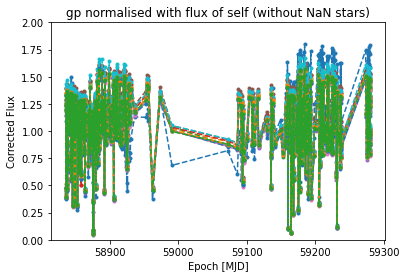

/home/bartjuh60/.local/lib/python3.8/site-packages/numpy/core/_asarray.py:83: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


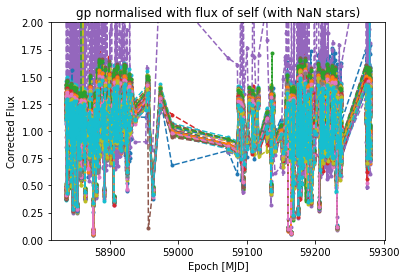

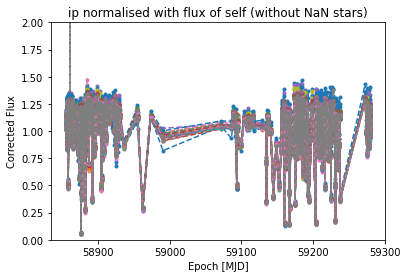

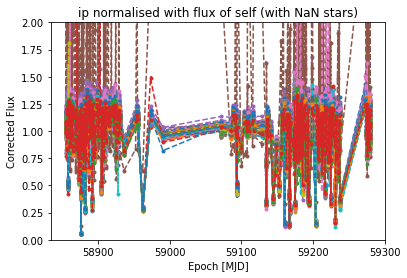

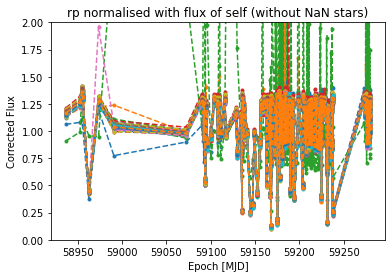

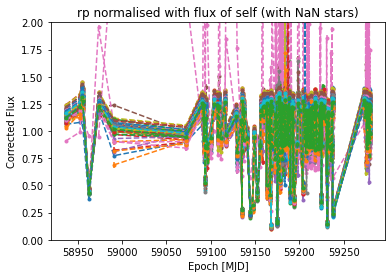

In [13]:
#Plot the flux of all stars normalised with their own flux to check if it worked
for f in filt:
    for i in np.arange(corN_stars[f])[star_withoutnan[f]]:
        plt.errorbar(corepoch[f],corflux[f][:,i]/meanflux_star[f][i],yerr=corfluxerr[f][:,i]/meanflux_star[f][i]\
                     ,fmt='--.',label=i)
    #plt.legend(bbox_to_anchor=(1, 1), loc='upper left')
    #plt.yscale('log')
    plt.title(f+" normalised with flux of self (without NaN stars)")
    plt.xlabel("Epoch [MJD]")
    plt.ylabel("Corrected Flux")
    plt.axis(ymin=0,ymax=2)
    plt.show()
    for i in np.arange(corN_stars[f]):#[star_withoutnan[f]]:
        plt.errorbar(corepoch[f],corflux[f][:,i]/meanflux_star[f][i],yerr=corfluxerr[f][:,i]/meanflux_star[f][i]\
                     ,fmt='--.',label=i)
    #plt.legend(bbox_to_anchor=(1, 1), loc='upper left')
    #plt.yscale('log')
    plt.title(f+" normalised with flux of self (with NaN stars)")
    plt.xlabel("Epoch [MJD]")
    plt.ylabel("Corrected Flux")
    plt.axis(ymin=0,ymax=2)
    plt.show()

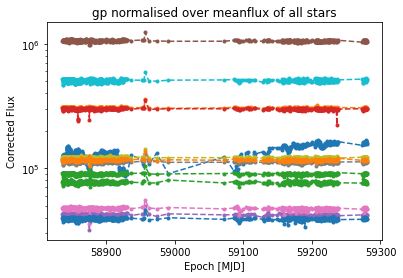

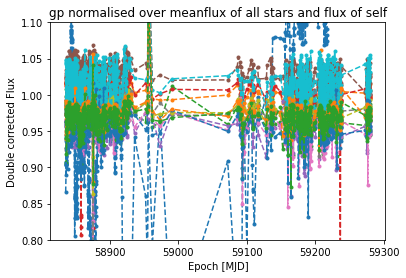

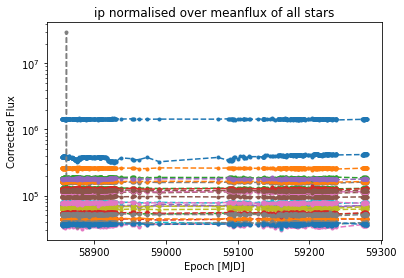

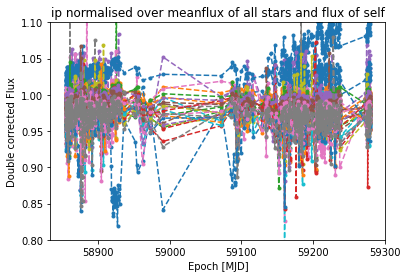

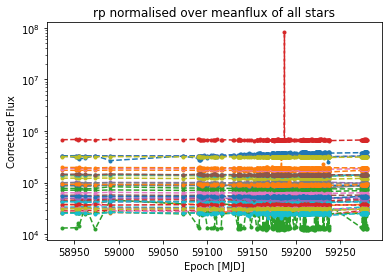

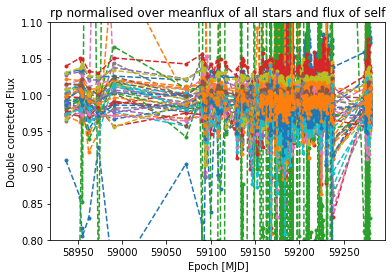

In [14]:
#Plot the epoch-corrected stellar flux.
#Also plot the double corrected plots (which is a straight line for constant stars)
for f in filt:
    for i in np.arange(corN_stars[f])[star_withoutnan[f]]:
        plt.plot(corepoch[f],normflux[f][:,i],linestyle='dashed',marker='.', label=i)
    #plt.legend(bbox_to_anchor=(1, 1), loc='upper left')
    plt.yscale('log')
    plt.title(f+" normalised over meanflux of all stars")
    plt.xlabel("Epoch [MJD]")
    plt.ylabel("Corrected Flux")
    plt.show()
    for i in np.arange(corN_stars[f])[star_withoutnan[f]]:
        plt.plot(corepoch[f],normflux[f][:,i]/meanflux_star[f][i],linestyle='dashed',marker='.', label=str(i))
    #plt.legend(bbox_to_anchor=(1, 1), loc='upper left')
    plt.title(f+" normalised over meanflux of all stars and flux of self")
    plt.xlabel("Epoch [MJD]")
    plt.ylabel("Double corrected Flux")
    #plt.yscale('log')
    plt.axis(ymin=0.8,ymax=1.1)
    plt.show()

# Filtering for stars with least variance or RMS

In [15]:
# Making an histogram for the double normalised flux (if star is constant, all values are in same bin)
hist_2nflux = {}
bins_2nflux = {}
N_bins = 29
for f in filt:
    tmp1 = []
    tmp2 = []
    mfsNaN = np.isnan(meanflux_star[f])
    for s in range(corN_stars[f]):
        if mfsNaN[s] == False:
            nonNaN = np.isnan(normflux[f][:,s]) == False
            #print (normflux[f][:,s][nonNaN]/meanflux_star[f][s])
            hist, bins = np.histogram(normflux[f][:,s][nonNaN]/meanflux_star[f][s],bins=N_bins, range=(0.5,1.5))
            tmp1.append(hist)
            tmp2.append(bins)
        else:
            print (f,s,"Will have all NaN values in hist_2nflux")
            tmp1.append([np.NaN]*N_bins)
            tmp2.append([np.NaN]*(N_bins+1))
    hist_2nflux[f] = np.array(tmp1)
    bins_2nflux[f] = np.array(tmp2)

# Calculating the variance in each double normalised flux
varflux_star = {}
for f in filt:
    tmp = []
    mfsNaN = np.isnan(meanflux_star[f])
    for s in range(corN_stars[f]):
        if mfsNaN[s] == False:
            nonNaN = np.isnan(normflux[f][:,s]) == False
            var = np.var(normflux[f][:,s][nonNaN]/meanflux_star[f][s])
            tmp.append(var)
        else:
            print (f,s, "Will have NaN value in varflux_star")
            tmp.append(np.NaN)
    varflux_star[f] = np.array(tmp)

RMSflux_star = {}
for f in filt:
    tmp = []
    mfsNaN = np.isnan(meanflux_star[f])
    for s in range(corN_stars[f]):
        if mfsNaN[s] == False:
            nonNaN = np.isnan(normflux[f][:,s]) == False
            RMS = np.sqrt(np.sum((normflux[f][:,s][nonNaN]/meanflux_star[f][s])**2)/len(normflux[f][:,s][nonNaN]))
            tmp.append(RMS)
        else:
            print (f,s, "Will have NaN value in RMS_star")
            tmp.append(np.NaN)
    RMSflux_star[f] = np.array(tmp)

gp 33 Will have all NaN values in hist_2nflux
gp 33 Will have NaN value in varflux_star
gp 33 Will have NaN value in RMS_star


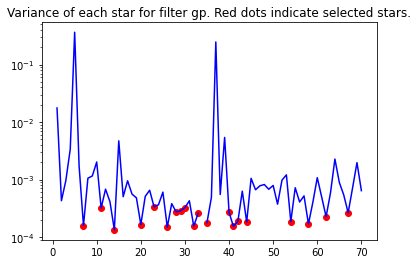

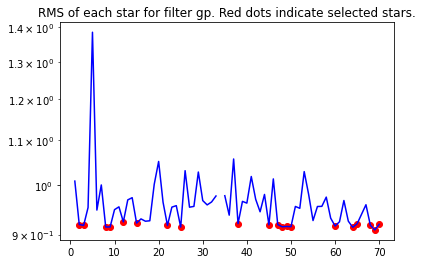

Var stars: [ 7 11 14 20 23 26 28 29 30 32 33 35 40 41 42 44 54 58 62 67]
RMS stars: [ 2  3  8  9 12 15 22 25 38 45 47 48 49 50 60 64 65 68 69 70]


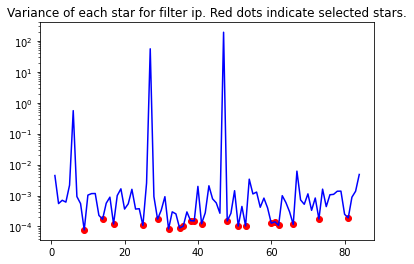

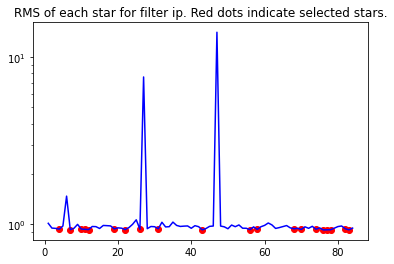

Var stars: [ 9 14 17 25 29 32 35 36 38 39 41 48 51 53 60 61 62 66 73 81]
RMS stars: [ 4  7 10 11 12 19 22 26 31 43 56 58 68 70 74 76 77 78 82 83]


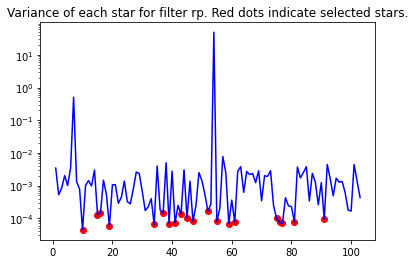

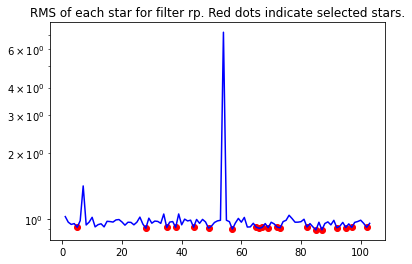

Var stars: [10 15 16 19 34 37 39 41 43 45 47 52 55 59 61 75 76 77 81 91]
RMS stars: [  5  28  35  38  44  49  57  65  66  67  69  72  73  82  85  87  92  95
  97 102]


In [16]:
# Selecting the N stars with least variance
var_mask = {}
RMS_mask = {}
nr_selected_stars = 20
for f in filt:
    sortindex1 = np.argsort(varflux_star[f])
    sortindex2 = np.argsort(RMSflux_star[f])
    tmp1 = []
    tmp2 = []
    for s in range(corN_stars[f]):
        tmp1.append(varflux_star[f][s] in varflux_star[f][sortindex1][:nr_selected_stars])
        tmp2.append(RMSflux_star[f][s] in RMSflux_star[f][sortindex2][:nr_selected_stars])
    var_mask[f] = np.array(tmp1)
    RMS_mask[f] = np.array(tmp2)
    
for f in filt:
    plt.plot(np.arange(corN_stars[f])+1, varflux_star[f],c='b')
    plt.scatter((np.arange(corN_stars[f])+1)[var_mask[f]], varflux_star[f][var_mask[f]], marker='o',c='r')
    plt.yscale('log')
    plt.title("Variance of each star for filter {}. Red dots indicate selected stars.".format(f))
    plt.show()
    plt.plot(np.arange(corN_stars[f])+1, RMSflux_star[f],c='b')
    plt.scatter((np.arange(corN_stars[f])+1)[RMS_mask[f]], RMSflux_star[f][RMS_mask[f]], marker='o',c='r')
    plt.yscale('log')
    plt.title("RMS of each star for filter {}. Red dots indicate selected stars.".format(f))
    plt.show()
    print ("Var stars:", np.arange(1,corN_stars[f]+1)[var_mask[f]])
    print ("RMS stars:", np.arange(1,corN_stars[f]+1)[RMS_mask[f]])
    

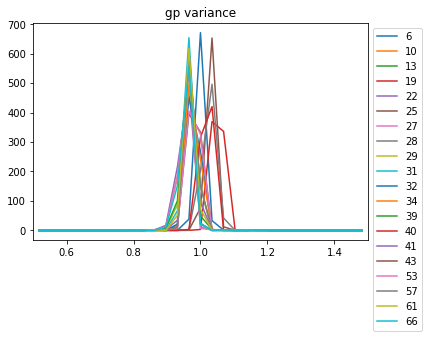

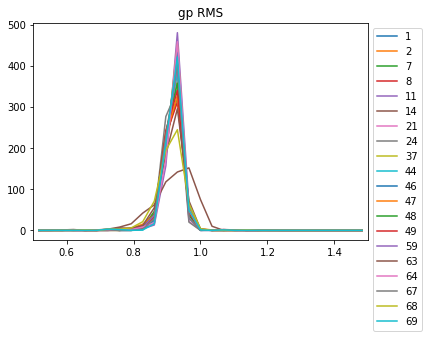

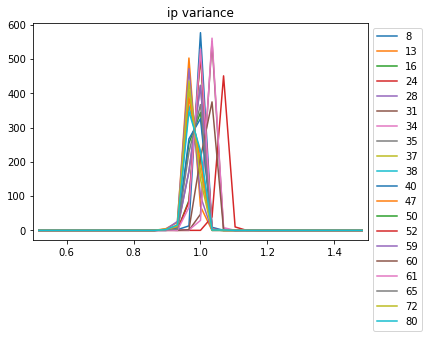

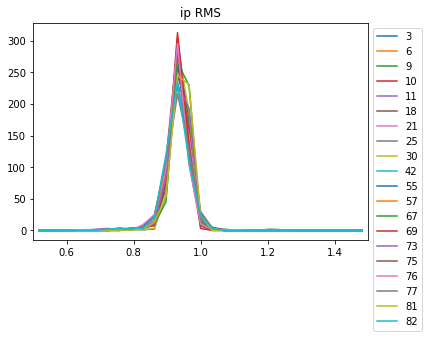

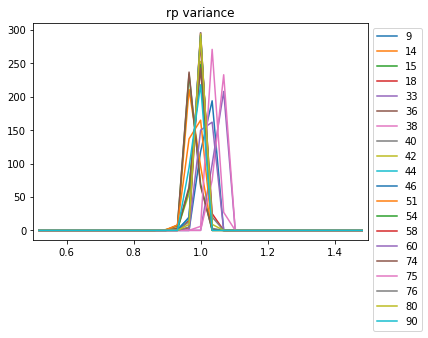

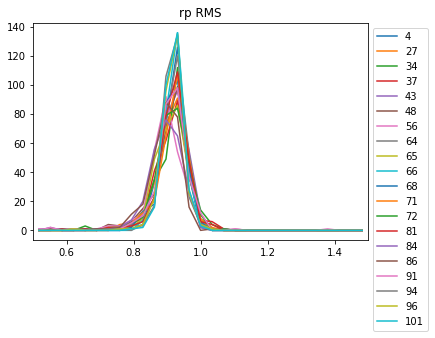

In [17]:
# Make a plot of the histogram of the double normalised fluxes for both the variance and RMS mask
for f in filt:
    for s in np.arange(corN_stars[f])[var_mask[f]]:
        plt.plot((bins_2nflux[f][s][:-1]+bins_2nflux[f][s][1:])/2,hist_2nflux[f][s],label=s)
    plt.axis(xmin=0.5,xmax=1.5)
    plt.legend(bbox_to_anchor=(1, 1), loc='upper left')
    plt.title(f+ ' variance')#+' '+str(s))
    plt.show()
    for s in np.arange(corN_stars[f])[RMS_mask[f]]:
        plt.plot((bins_2nflux[f][s][:-1]+bins_2nflux[f][s][1:])/2,hist_2nflux[f][s],label=s)
    plt.axis(xmin=0.5,xmax=1.5)
    plt.title(f+ ' RMS')#+' '+str(s))
    plt.legend(bbox_to_anchor=(1, 1), loc='upper left')
    plt.show()

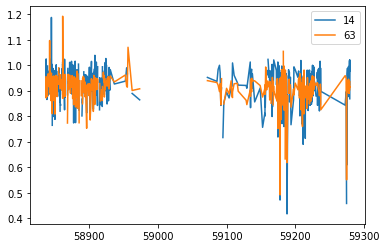

102


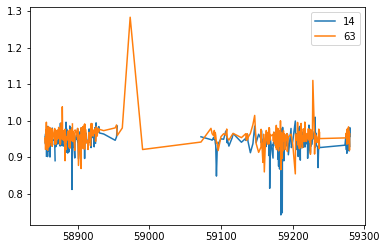

3


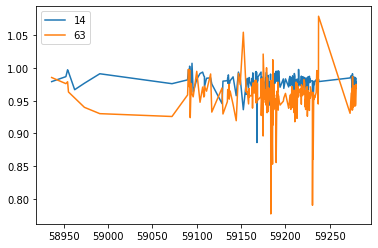

1


In [18]:
# plotting curve of star 63 to see why the histogram is so low
for f in filt:
    for s in [14,63]:
        plt.plot(corepoch[f],normflux[f][:,s]/meanflux_star[f][s], label=s)
    plt.legend()
    #plt.yscale('log')
    plt.show()
    print (np.sum(np.isnan(normflux[f][:,63])))

# Calculate the new normalisation factor with only using the stable stars

In [19]:
# Again create the double normalisation, but now only using the best of the best stars

# Meanflux star stays the same

# Calculate the weighted mean normalised flux for each epoch & the rror in this weighted mean normalised flux
newnormfac_epoch = {}
newnormfacerr_epoch = {}
for f in filt:
    tmp = []
    for i in range(len(corepoch[f])):
        #Exclude the NaN's for the mean
        nonNaN = np.isnan(corflux[f][i]) == False
        nonNaN *= np.isnan(meanflux_star[f])== False #sometimes 
        mask = nonNaN*var_mask[f]
        #print (f,np.sum(nonNaN), np.sum(nonNaN==False))
        if np.sum(nonNaN) != 0:
            mfluxep = (corflux[f][i][mask]/meanflux_star[f][mask])
            mfluxerrep = np.sqrt((corfluxerr[f][i]/meanflux_star[f])**2 +\
                                 (corflux[f][i]*meanfluxerr_star[f]/(meanflux_star[f]**2))**2)[mask]
            weight = 1/mfluxerrep**2
            tmp.append(np.sum(weight*mfluxep)/np.sum(weight))
            tmp2.append(np.sum(weight))
        else:
            print ("normfac_epoch: Filter {} and epoch {} has all NaN values".format(f,i))
            tmp.append(np.NaN)
            tmp2.append(np.NaN)
    newnormfac_epoch[f] = np.array(tmp)
    newnormfacerr_epoch[f] = np.array(tmp2)

print ("Amount of NaN values in normfac(err)_epoch:")
for f in filt:
    print (f,np.sum(np.isnan(normfac_epoch[f])))
    print (f,np.sum(np.isnan(normfacerr_epoch[f])))

# Calculate the flux of each star, corrected by the normalised mean flux at a certain epoch
newnormflux = {}
#newnormfluxerr = {}
for f in filt:
    tmp = []
    #tmp2 = []
    for i in np.arange(corN_stars[f])[var_mask[f]]:
        nflux = corflux[f][:,i]/newnormfac_epoch[f]
        #nfluxerr = np.sqrt((corfluxerr[f][:,i]/newnormfac_epoch[f])**2 + \
        #                   (corflux[f][:,i]*newnormfacerr_epoch[f]/(normfac_epoch[f]**2))**2)
        tmp.append(nflux)
        #tmp2.append(nfluxerr)
    newnormflux[f] = np.array(tmp).transpose()
    #normfluxerr[f] = np.array(tmp2).transpose()
    #print (normflux[f])

#print ("Amount of NaN values in normflux(err):")
#for f in filt:
#    print (f,np.sum(np.isnan(normflux[f])), "vs", np.sum(np.isnan(corflux[f])))
#    print (f,np.sum(np.isnan(normfluxerr[f])), "vs", np.sum(np.isnan(corfluxerr[f])))


#Calculate the flux of each star, correct by the normalised mean flux at a certain epoch, devided by their own mean
# (so the double normalised flux)


Amount of NaN values in normfac(err)_epoch:
gp 0
gp 0
ip 0
ip 0
rp 0
rp 0


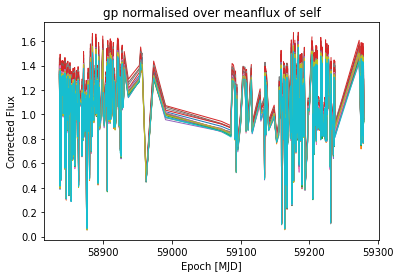

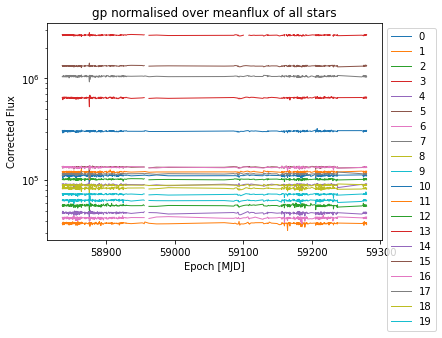

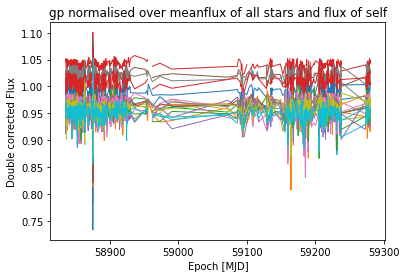

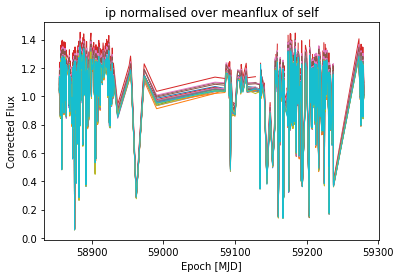

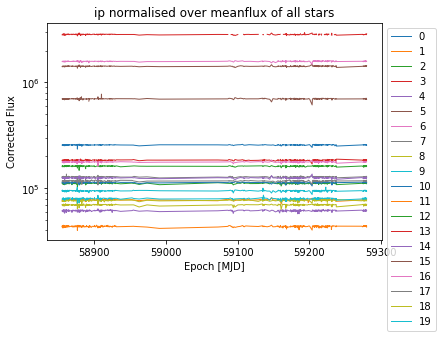

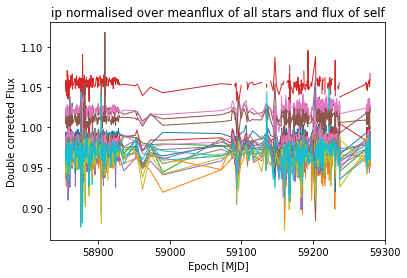

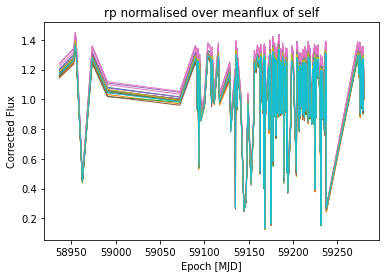

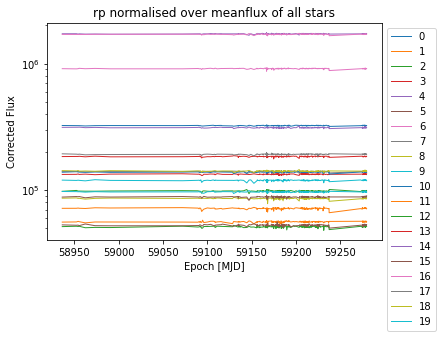

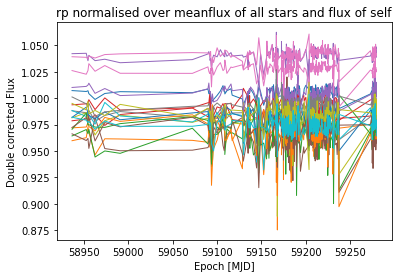

In [20]:
for f in filt:
    #plt.figure(figsize=(8,6))
    for i in np.arange(corN_stars[f])[var_mask[f]]:
        plt.plot(corepoch[f],corflux[f][:,i]/meanflux_star[f][i],linewidth=1, label=i)
    #plt.legend(bbox_to_anchor=(1, 1), loc='upper left')
    #plt.yscale('log')
    plt.title(f+" normalised over meanflux of self")
    plt.xlabel("Epoch [MJD]")
    plt.ylabel("Corrected Flux")
    plt.show()
    #plt.figure(figsize=(8,6))
    for i in range(nr_selected_stars):
        plt.plot(corepoch[f],newnormflux[f][:,i],linewidth=1, label=i)
    plt.legend(bbox_to_anchor=(1, 1), loc='upper left')
    plt.yscale('log')
    plt.title(f+" normalised over meanflux of all stars")
    plt.xlabel("Epoch [MJD]")
    plt.ylabel("Corrected Flux")
    plt.show()
    #plt.figure(figsize=(8,6))
    for i in range(nr_selected_stars):
        plt.plot(corepoch[f],newnormflux[f][:,i]/meanflux_star[f][var_mask[f]][i],linewidth=1, label=str(i))
    #plt.legend(bbox_to_anchor=(1, 1), loc='upper left')
    plt.title(f+" normalised over meanflux of all stars and flux of self")
    plt.xlabel("Epoch [MJD]")
    plt.ylabel("Double corrected Flux")
    #plt.yscale('log')
    #plt.axis(ymin=0.8,ymax=1.1)
    plt.show()

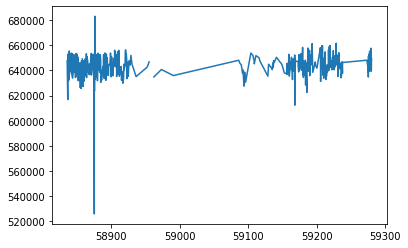

Min value: 525864.5208719581
Max value: 683063.0121927954
Min value index: (array([266]),)
Max value index: (array([273]),)


In [21]:
#make another hand picked selection of bad epochs for certain filters:

#plot the stars that have the bad photometry easely visible:
noNaN = {}
for f in ['gp']: # put in the filter you want
    for s in [13]: # put in the star
        plt.plot(corepoch[f],newnormflux[f][:,s])
        plt.show()
        noNaN[f] = np.isnan(newnormflux[f][:,s]) == False

        min_noNaNindex = np.argmin(newnormflux[f][:,s][noNaN[f]])
        max_noNaNindex = np.argmax(newnormflux[f][:,s][noNaN[f]])
        print ('Min value:',newnormflux[f][:,s][noNaN[f]][min_noNaNindex])
        print ('Max value:',newnormflux[f][:,s][noNaN[f]][max_noNaNindex])

        print ('Min value index:',np.where(newnormflux[f][:,s] == newnormflux[f][:,s][noNaN[f]][min_noNaNindex]))
        print ('Max value index:',np.where(newnormflux[f][:,s] == newnormflux[f][:,s][noNaN[f]][max_noNaNindex]))

In [22]:
# Put the index for the bad images inside this dictionary
bad_img = {
    'gp':[266],
    'ip':[],
    'rp':[]
}

# Now you can mask the epoch & flux values with now_e to filter the bad photometry
new_e = {}
for f in filt:
    msk = []
    for e in np.arange(len(corepoch[f])):
        msk.append(e not in bad_img[f])
    new_e[f] = np.array(msk)

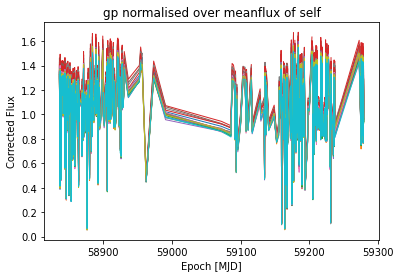

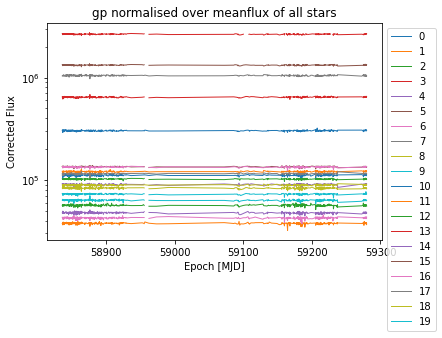

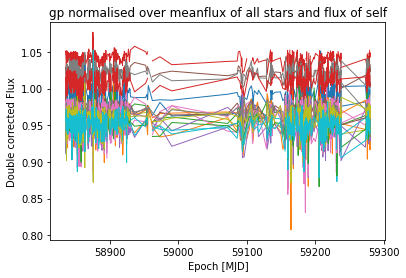

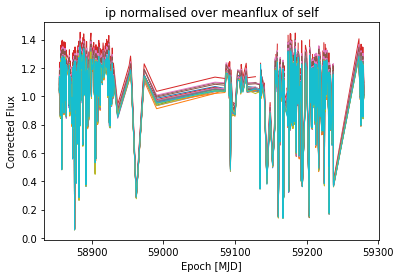

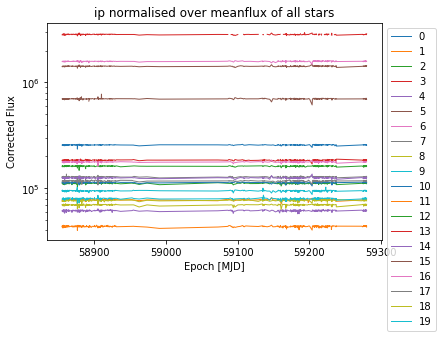

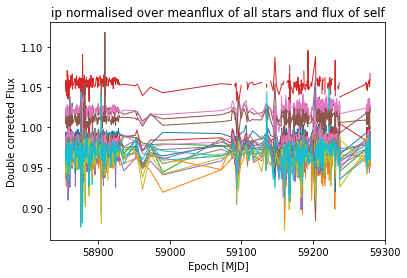

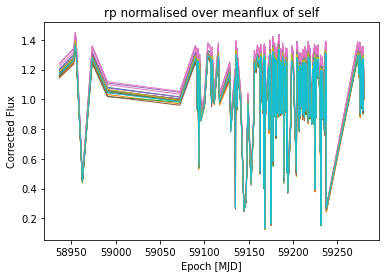

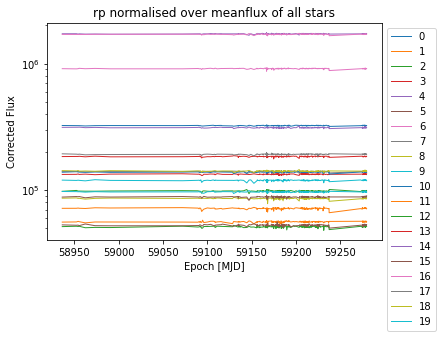

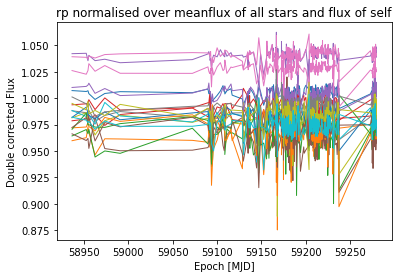

In [23]:
# check if all is well now:
for f in filt:
    #plt.figure(figsize=(8,6))
    for i in np.arange(corN_stars[f])[var_mask[f]]:
        plt.plot(corepoch[f][new_e[f]],(corflux[f][:,i]/meanflux_star[f][i])[new_e[f]],linewidth=1, label=i)
    #plt.legend(bbox_to_anchor=(1, 1), loc='upper left')
    #plt.yscale('log')
    plt.title(f+" normalised over meanflux of self")
    plt.xlabel("Epoch [MJD]")
    plt.ylabel("Corrected Flux")
    plt.show()
    #plt.figure(figsize=(8,6))
    for i in range(nr_selected_stars):
        plt.plot(corepoch[f][new_e[f]],newnormflux[f][:,i][new_e[f]],linewidth=1, label=i)
    plt.legend(bbox_to_anchor=(1, 1), loc='upper left')
    plt.yscale('log')
    plt.title(f+" normalised over meanflux of all stars")
    plt.xlabel("Epoch [MJD]")
    plt.ylabel("Corrected Flux")
    plt.show()
    #plt.figure(figsize=(8,6))
    for i in range(nr_selected_stars):
        plt.plot(corepoch[f][new_e[f]],(newnormflux[f][:,i]/meanflux_star[f][var_mask[f]][i])[new_e[f]],linewidth=1, label=str(i))
    #plt.legend(bbox_to_anchor=(1, 1), loc='upper left')
    plt.title(f+" normalised over meanflux of all stars and flux of self")
    plt.xlabel("Epoch [MJD]")
    plt.ylabel("Double corrected Flux")
    #plt.yscale('log')
    #plt.axis(ymin=0.8,ymax=1.1)
    plt.show()

In [24]:
# Because I'm getting lost in the datasets, masks en everything, I will export the data to dataredred
#  & start in a new file

# Get the star number and coordinates for the selected stars
selecteds = {}
selecteds_coords = {}
standards = ascii.read('standards.txt')
#print (standards)
for f in filt:
    selecteds[f] = np.arange(N_stars)[smask[f]][var_mask[f]] # Starnr is counting from 1 to 161
    tmp1 = np.array(standards[smask[f]][var_mask[f]]['RA'])
    tmp2 = np.array(standards[smask[f]][var_mask[f]]['Dec'])
    selecteds_coords[f] = np.array([tmp1,tmp2]).transpose()

# Prepare lists to write to for the meta-data file
t_fits_name, t_filename, t_epoch, t_filter, t_airmass = [],[],[],[],[]

for f in filt:
    for e in np.arange(len(corepoch[f]))[new_e[f]]:
        
        filename = '../dataredred/'+str(round(trunc(corepoch[f][e]*1e5)*1e-5,6)) + '_' + f + '.txt'
        
        # Add the meta-data to the corrosponding lists
        t_filename.append(filename)
        t_fits_name.append(corfits_name[f][e])
        t_epoch.append(corepoch[f][e])
        t_filter.append(f)
        t_airmass.append(corairmass[f][e])
        
        # Create the reduced reduced datafiles (with J0600 as the first data & the N best stars after that)
        flux = np.zeros(nr_selected_stars+1)
        flux[0], flux[1:] = corflux[f][e,0], corflux[f][e][var_mask[f]]
        fluxerr = np.zeros(nr_selected_stars+1)
        fluxerr[0], fluxerr[1:] = corfluxerr[f][e,0], corfluxerr[f][e][var_mask[f]]
        
        starnr = np.zeros(nr_selected_stars+1,dtype=int)
        starnr[0],starnr[1:] = 0, selecteds[f]
        
        # Write to the files
        filecontent = Table([starnr,flux,fluxerr], names=['STARNR','FLUX','FLUXERR'])
        ascii.write(filecontent, filename, overwrite=True)


# Write the epoch meta-data to a file
filecontent = Table([t_fits_name, t_filename, t_epoch, t_filter, t_airmass],
                   names=['IMAGE','FILENAME','EPOCH','FILTER','AIRMASS'])
filepath = "../dataredred/J0600_meta-data_epoch.txt"

ascii.write(filecontent,filepath,overwrite=True)


# We also want the meta data for the selected stars (mainly the coordinates, but also the starnr)
cont = []
nam = []
for f in filt:
    starnr = np.zeros(nr_selected_stars+1,dtype=int)
    starnr[0],starnr[1:] = 0, selecteds[f]
    cont.append(starnr)
    
    star_coord = np.zeros((nr_selected_stars+1,2))
    star_coord[0] = [standards['RA'][0], standards['Dec'][0]]
    star_coord[1:] = selecteds_coords[f]
    cont.append(star_coord[:,0])
    cont.append(star_coord[:,1])
    
    nam.append(f+'_star')
    nam.append(f+'_RA')
    nam.append(f+'_Dec')
    
filecontent = Table(cont,names=nam)
filepath = "../dataredred/J0600_meta-data_stars.txt"

ascii.write(filecontent,filepath,overwrite=True)

